# Initialising Spark Session


In [239]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("customerAnalysis").getOrCreate()


In [240]:
from pyspark.sql.types import *
from pyspark.sql.functions import *

# Creating Data Frame


In [241]:
spark.conf.set("spark.sql.legacy.timeParserPolicy", "LEGACY")
columns = ["timestamp_col"]

In [242]:
df_1 = spark.read.option("header", True).option("inferSchema", True).csv("dataset/file1.csv")
df_2= spark.read.option("header", True).option("inferSchema", True).csv("dataset/file2.csv")


In [243]:
df = df_1.union(df_2)

In [244]:
df.printSchema()

root
 |-- Invoice: string (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Quantity: integer (nullable = true)
 |-- InvoiceDate: string (nullable = true)
 |-- Price: double (nullable = true)
 |-- CustomerID: integer (nullable = true)
 |-- Country: string (nullable = true)



In [245]:
df.show()

+-------+---------+--------------------+--------+------------+-----+----------+--------------+
|Invoice|StockCode|         Description|Quantity| InvoiceDate|Price|CustomerID|       Country|
+-------+---------+--------------------+--------+------------+-----+----------+--------------+
| 489434|    85048|15CM CHRISTMAS GL...|      12|12/1/09 7:45| 6.95|     13085|United Kingdom|
| 489434|   79323P|  PINK CHERRY LIGHTS|      12|12/1/09 7:45| 6.75|     13085|United Kingdom|
| 489434|   79323W| WHITE CHERRY LIGHTS|      12|12/1/09 7:45| 6.75|     13085|United Kingdom|
| 489434|    22041|"RECORD FRAME 7""...|      48|12/1/09 7:45|  2.1|     13085|United Kingdom|
| 489434|    21232|STRAWBERRY CERAMI...|      24|12/1/09 7:45| 1.25|     13085|United Kingdom|
| 489434|    22064|PINK DOUGHNUT TRI...|      24|12/1/09 7:45| 1.65|     13085|United Kingdom|
| 489434|    21871| SAVE THE PLANET MUG|      24|12/1/09 7:45| 1.25|     13085|United Kingdom|
| 489434|    21523|FANCY FONT HOME S...|      10|1

# Data Cleaning and Filtering

In [246]:
df_filtered=df.filter((col('Quantity')>0) & (col('Price')>0) & (col('CustomerID').isNotNull()))

In [247]:
df_filtered.show()

+-------+---------+--------------------+--------+------------+-----+----------+--------------+
|Invoice|StockCode|         Description|Quantity| InvoiceDate|Price|CustomerID|       Country|
+-------+---------+--------------------+--------+------------+-----+----------+--------------+
| 489434|    85048|15CM CHRISTMAS GL...|      12|12/1/09 7:45| 6.95|     13085|United Kingdom|
| 489434|   79323P|  PINK CHERRY LIGHTS|      12|12/1/09 7:45| 6.75|     13085|United Kingdom|
| 489434|   79323W| WHITE CHERRY LIGHTS|      12|12/1/09 7:45| 6.75|     13085|United Kingdom|
| 489434|    22041|"RECORD FRAME 7""...|      48|12/1/09 7:45|  2.1|     13085|United Kingdom|
| 489434|    21232|STRAWBERRY CERAMI...|      24|12/1/09 7:45| 1.25|     13085|United Kingdom|
| 489434|    22064|PINK DOUGHNUT TRI...|      24|12/1/09 7:45| 1.65|     13085|United Kingdom|
| 489434|    21871| SAVE THE PLANET MUG|      24|12/1/09 7:45| 1.25|     13085|United Kingdom|
| 489434|    21523|FANCY FONT HOME S...|      10|1

# Customer Spending Analysis


In [248]:

customer_spend_df = df_filtered.groupBy("CustomerID").agg(
    round(spark_sum(col("Quantity") * col("Price")), 2).alias("Total Spend")
)

top_customers = customer_spend_df.orderBy(desc("Total Spend")).limit(10)

In [249]:
top_customers.show()

+----------+-----------+
|CustomerID|Total Spend|
+----------+-----------+
|     18102|  608821.65|
|     14646|  528602.52|
|     14156|  313946.37|
|     14911|  295972.63|
|     17450|  246973.09|
|     13694|  196482.81|
|     17511|  175603.55|
|     16446|   168472.5|
|     16684|  147142.77|
|     12415|  144458.37|
+----------+-----------+



# Frequently Bought Products

In [250]:
df_FreqBought = df_filtered.groupBy('StockCode').agg(sum((col('Quantity'))).alias('FrequentlyBought'))
top_products = df_FreqBought.orderBy(desc("FrequentlyBought")).limit(10)
top_products.show()

+---------+----------------+
|StockCode|FrequentlyBought|
+---------+----------------+
|    84077|          109169|
|   85099B|           94983|
|   85123A|           93697|
|    21212|           91263|
|    23843|           80995|
|    84879|           79913|
|    22197|           77971|
|    23166|           77916|
|    17003|           71129|
|    21977|           55270|
+---------+----------------+



# Monthly Sales

In [270]:
from pyspark.sql.functions import to_timestamp, date_format, col, sum as spark_sum

df = df.withColumn("InvoiceDate", to_timestamp(col("InvoiceDate"), "M/d/yy H:mm"))

df = df.withColumn("MonthYear", date_format(col("InvoiceDate"), "yyyy-MM"))

monthly_sales = df.groupBy("MonthYear").agg(
    round(spark_sum(col("Quantity") * col("Price")), 2).alias("TotalSales")
)

monthly_sales = monthly_sales.orderBy("MonthYear")

monthly_sales.show(50, False)


+---------+----------+
|MonthYear|TotalSales|
+---------+----------+
|2009-12  |799847.11 |
|2010-01  |624032.89 |
|2010-02  |533091.43 |
|2010-03  |765848.76 |
|2010-04  |590580.43 |
|2010-05  |615322.83 |
|2010-06  |679786.61 |
|2010-07  |575236.36 |
|2010-08  |656776.34 |
|2010-09  |853650.43 |
|2010-10  |1045168.35|
|2010-11  |1422654.64|
|2010-12  |1126445.47|
|2011-01  |560000.26 |
|2011-02  |498062.65 |
|2011-03  |683267.08 |
|2011-04  |493207.12 |
|2011-05  |723333.51 |
|2011-06  |691123.12 |
|2011-07  |681300.11 |
|2011-08  |682680.51 |
|2011-09  |1019687.62|
|2011-10  |1070704.67|
|2011-11  |1461756.25|
|2011-12  |433686.01 |
+---------+----------+



# Yearly Sales

In [271]:
from pyspark.sql.functions import to_timestamp, col, sum as spark_sum, year

df = df.withColumn("InvoiceDate", to_timestamp(col("InvoiceDate"), "M/d/yy H:mm"))

df = df.withColumn("Year", year(col("InvoiceDate")))

yearly_sales = df.groupBy("Year").agg(
    round(spark_sum(col("Quantity") * col("Price")), 2).alias("TotalSales")
).orderBy("Year")

yearly_sales.show(50, False)


+----+----------+
|Year|TotalSales|
+----+----------+
|2009|799847.11 |
|2010|9488594.54|
|2011|8998808.91|
+----+----------+



# Sales Per Store 



In [272]:
from pyspark.sql.functions import col, sum

sales_per_store = df.groupBy("Country").agg(
    round(sum(col("Quantity") * col("Price")), 2).alias("TotalSales")
)

sales_per_store.show(10, False)


+-----------+----------+
|Country    |TotalSales|
+-----------+----------+
|Sweden     |87809.42  |
|Germany    |417988.56 |
|France     |328191.8  |
|Greece     |18995.49  |
|Belgium    |63574.49  |
|Finland    |29514.45  |
|Nigeria    |-6.66     |
|Unspecified|9687.32   |
|Italy      |30679.35  |
|EIRE       |615519.55 |
+-----------+----------+
only showing top 10 rows



# Customer Purchase Frequency 


In [273]:
customer_purchase_frequency = df.groupBy("CustomerID").agg(
    count("Invoice").alias("PurchaseFrequency")
)

customer_purchase_frequency.show(10, False)


+----------+-----------------+
|CustomerID|PurchaseFrequency|
+----------+-----------------+
|13623     |303              |
|17679     |105              |
|17389     |449              |
|18051     |58               |
|13289     |16               |
|17753     |73               |
|15727     |694              |
|15967     |502              |
|15254     |68               |
|12471     |1298             |
+----------+-----------------+
only showing top 10 rows



# Customer Segmentation (RFM Analysis)


In [274]:
latest_date = df.select(max("InvoiceDate")).collect()[0][0]

rfm_df = df.groupBy("CustomerID").agg(
    datediff(lit(latest_date), max("InvoiceDate")).alias("Recency"),
    count("Invoice").alias("Frequency"),
    round(sum(col("Quantity") * col("Price")), 2).alias("Monetary")
)

rfm_df.show(10, False)


+----------+-------+---------+--------+
|CustomerID|Recency|Frequency|Monetary|
+----------+-------+---------+--------+
|13623     |30     |303      |2446.36 |
|17679     |52     |105      |3166.56 |
|17389     |0      |449      |54587.03|
|18051     |634    |58       |2275.98 |
|13289     |723    |16       |307.95  |
|17753     |464    |73       |388.06  |
|15727     |16     |694      |9445.51 |
|15967     |23     |502      |3019.2  |
|15254     |127    |68       |1073.4  |
|12471     |2      |1298     |37948.61|
+----------+-------+---------+--------+
only showing top 10 rows



# Country-wise Revenue Analysis

In [275]:
country_revenue_df = df_filtered.groupBy("Country").agg(
    round(sum(col("Quantity") * col("Price")), 2).alias("TotalRevenue")
)

country_revenue_df.orderBy(desc("TotalRevenue")).show(10)

+--------------+-------------+
|       Country| TotalRevenue|
+--------------+-------------+
|United Kingdom|1.472314752E7|
|          EIRE|    621631.11|
|   Netherlands|    554232.34|
|       Germany|    431262.46|
|        France|    355257.47|
|     Australia|    169968.11|
|         Spain|    109178.53|
|   Switzerland|    100365.34|
|        Sweden|     91549.72|
|       Denmark|     69862.19|
+--------------+-------------+
only showing top 10 rows



# Average Order Value (AOV) Analysis

In [276]:
order_spend_df = df_filtered.groupBy("Invoice").agg(
    round(sum(col("Quantity") * col("Price")), 2).alias("OrderTotal")
)

aov_df = order_spend_df.agg(round(avg("OrderTotal"), 2).alias("AverageOrderValue"))
aov_df.show()

+-----------------+
|AverageOrderValue|
+-----------------+
|           479.95|
+-----------------+



# Store Processed Data in Parquet Format

In [277]:
customer_spend_df.write.mode("overwrite").parquet("output/customer_spending.parquet")
top_products.write.mode("overwrite").parquet("output/top_products.parquet")
monthly_sales.write.mode("overwrite").parquet("output/monthly_sales.parquet")
yearly_sales.write.mode("overwrite").parquet("output/yearly_sales.parquet")
customer_purchase_frequency.write.mode("overwrite").parquet("output/purchase_frequency.parquet")
sales_per_store.write.mode("overwrite").parquet("output/sales_per_store.parquet")
country_revenue_df.write.mode("overwrite").parquet("output/country_revenue.parquet")
order_spend_df.write.mode("overwrite").parquet("output/order_spend.parquet")

# Convert to Pandas for Visualization

In [278]:
import pandas as pd
top_customers_pd = top_customers.toPandas()
top_products_pd = top_products.toPandas()
monthly_sales_pd = monthly_sales.toPandas()
yearly_sales_pd = yearly_sales.toPandas()
sales_per_store_pd = sales_per_store.toPandas()
purchase_frequency_pd = customer_purchase_frequency.toPandas()
rfm_pd = rfm_df.toPandas()
country_revenue_pd = country_revenue_df.toPandas().sort_values("TotalRevenue", ascending=False).head(10)
order_spend_pd = order_spend_df.toPandas()

# Top Customers Spending Visualization

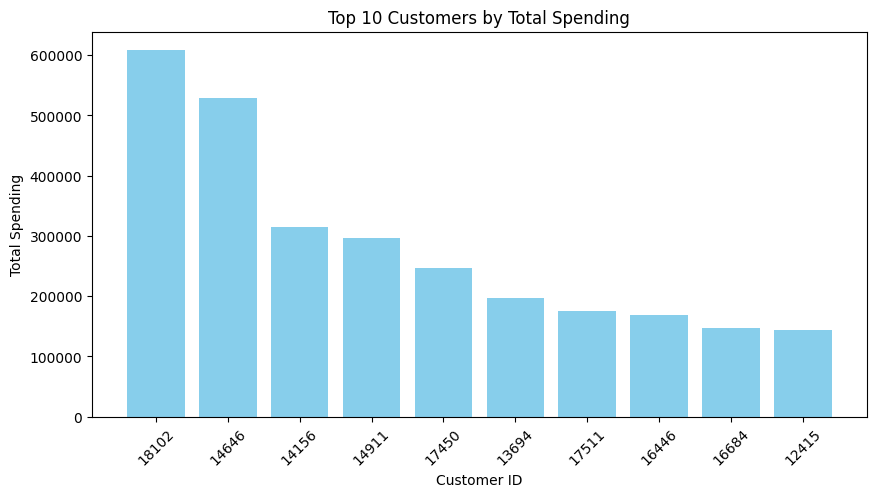

In [279]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.bar(top_customers_pd['CustomerID'].astype(str), top_customers_pd['Total Spend'], color='skyblue')
plt.xlabel("Customer ID")
plt.ylabel("Total Spending")
plt.title("Top 10 Customers by Total Spending")
plt.xticks(rotation=45)
plt.show()

# Most Purchased Product Visualization

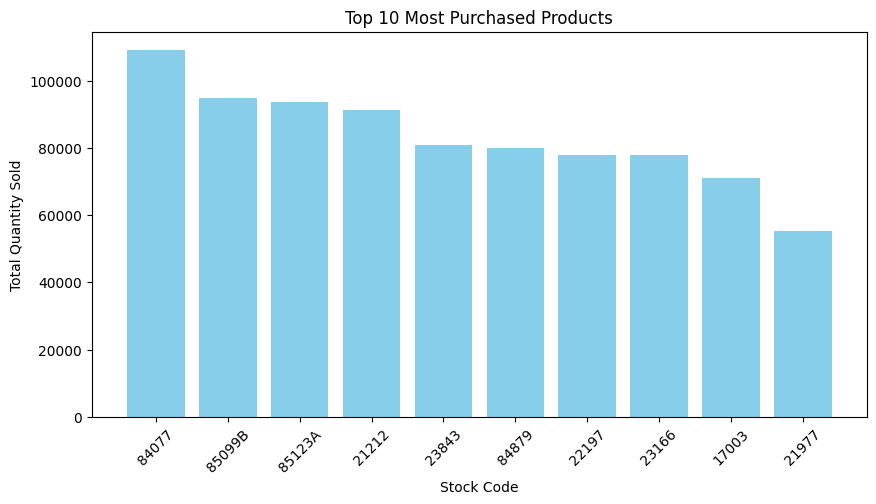

In [280]:
plt.figure(figsize=(10,5))
plt.bar(top_products_pd['StockCode'].astype(str), top_products_pd['FrequentlyBought'], color='skyblue')
plt.xlabel("Stock Code")
plt.ylabel("Total Quantity Sold")
plt.title("Top 10 Most Purchased Products")
plt.xticks(rotation=45)
plt.show()

# Monthly Sales Trend Visualization




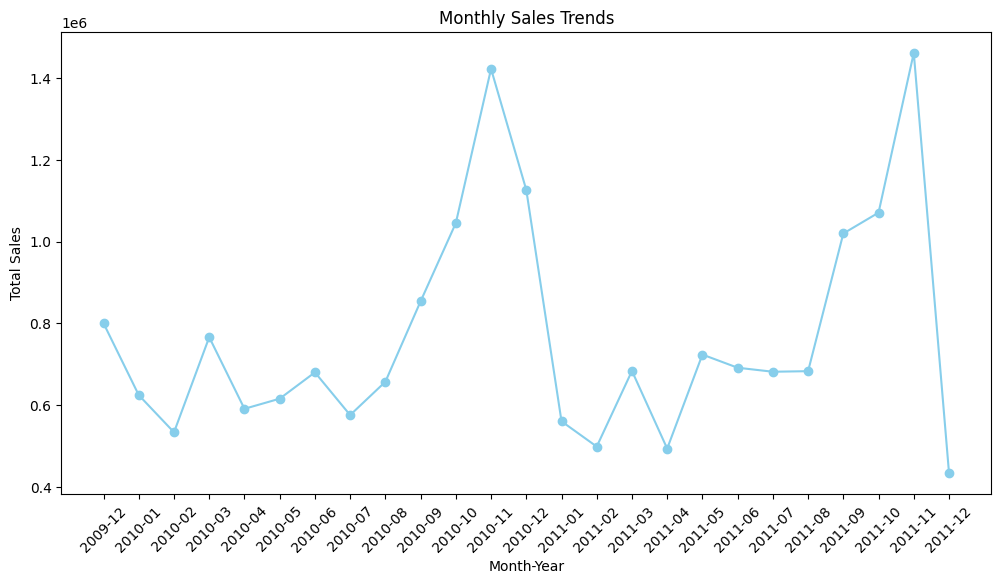

In [281]:
plt.figure(figsize=(12,6))
plt.plot(monthly_sales_pd['MonthYear'], monthly_sales_pd['TotalSales'], marker='o', linestyle='-', color='skyblue')
plt.xlabel("Month-Year")
plt.ylabel("Total Sales")
plt.title("Monthly Sales Trends")
plt.xticks(rotation=45)
plt.show()


# Yearly Sales Trend Visualization


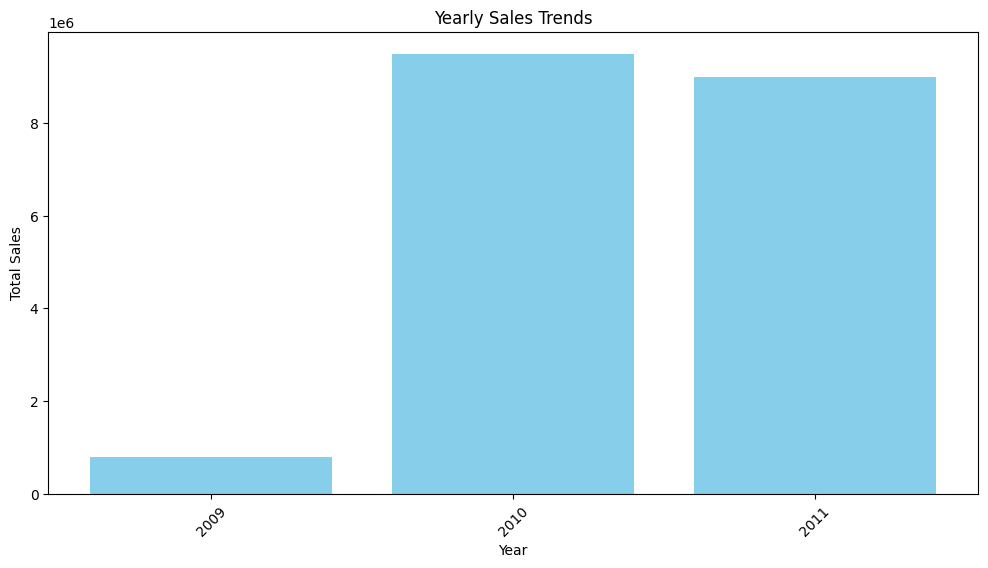

In [282]:
if "TotalSalesYear" not in yearly_sales_pd.columns:
    yearly_sales_pd.rename(columns={"TotalSales": "TotalSalesYear"}, inplace=True)

yearly_sales_pd['Year'] = yearly_sales_pd['Year'].astype(str)

# Plot
plt.figure(figsize=(12,6))
plt.bar(yearly_sales_pd['Year'], yearly_sales_pd['TotalSalesYear'], color='skyblue')
plt.xlabel("Year")
plt.ylabel("Total Sales")
plt.title("Yearly Sales Trends")
plt.xticks(rotation=45)
plt.show()


# Sales Per Store Visualization

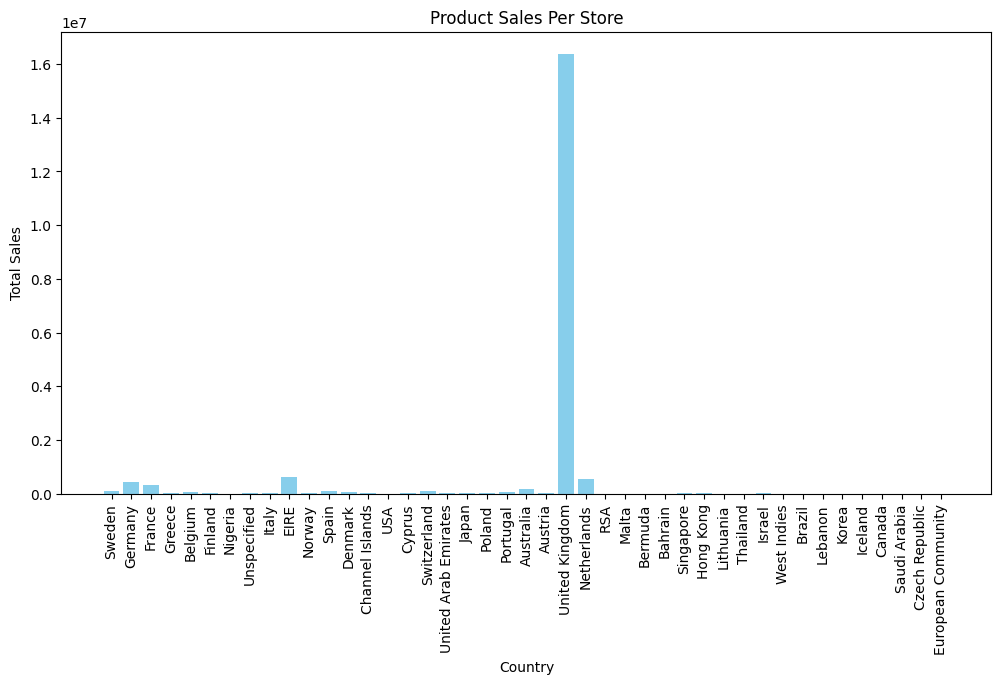

In [283]:
plt.figure(figsize=(12,6))
plt.bar(sales_per_store_pd['Country'], sales_per_store_pd['TotalSales'], color='skyblue')
plt.xlabel("Country")
plt.ylabel("Total Sales")
plt.title("Product Sales Per Store")
plt.xticks(rotation=90)
plt.show()


# Customer Purchase Frequency Visualization




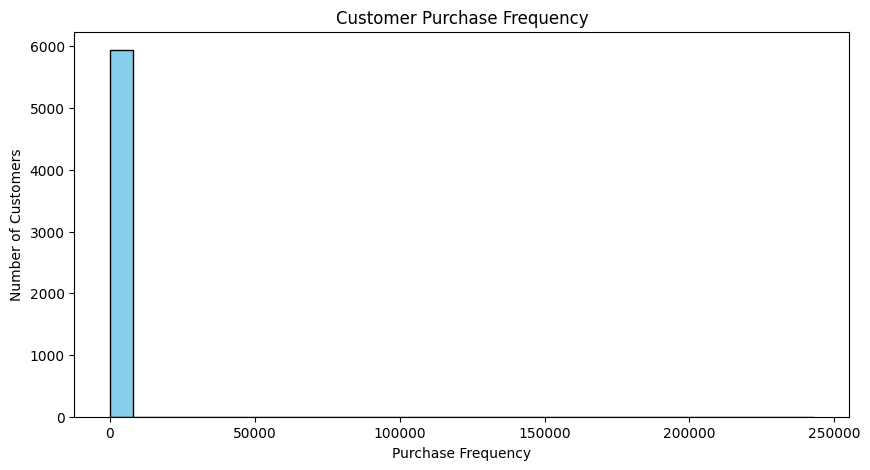

In [284]:
plt.figure(figsize=(10,5))
plt.hist(purchase_frequency_pd['PurchaseFrequency'], bins=30, color='skyblue', edgecolor='black')
plt.xlabel("Purchase Frequency")
plt.ylabel("Number of Customers")
plt.title("Customer Purchase Frequency")
plt.show()

# Country-wise Revenue Analysis

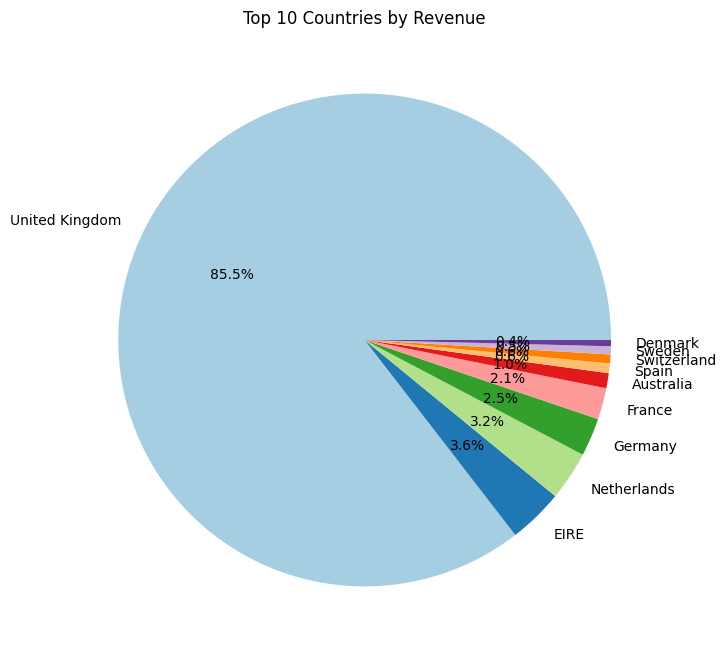

In [285]:
plt.figure(figsize=(8, 8))
plt.pie(country_revenue_pd["TotalRevenue"], labels=country_revenue_pd["Country"], autopct="%1.1f%%", colors=plt.cm.Paired.colors)
plt.title("Top 10 Countries by Revenue")
plt.show()

# Order Values Distribution

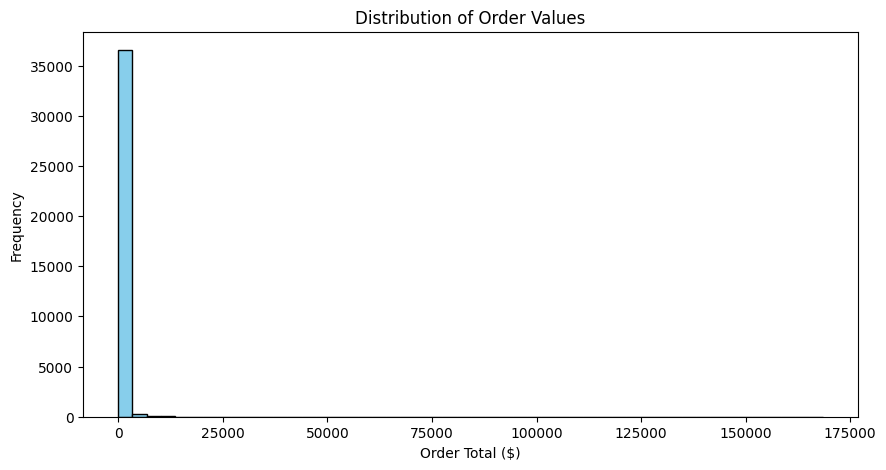

25/04/04 20:20:02 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 727210 ms exceeds timeout 120000 ms
25/04/04 20:20:02 WARN SparkContext: Killing executors is not supported by current scheduler.
25/04/04 20:20:07 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$

In [ ]:
plt.figure(figsize=(10, 5))
plt.hist(order_spend_pd["OrderTotal"], bins=50, color="skyblue", edgecolor="black")
plt.xlabel("Order Total ($)")
plt.ylabel("Frequency")
plt.title("Distribution of Order Values")
plt.show()

In [268]:
# spark.stop()